In [30]:
import pandas as pd
import xgboost as xgb
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
import matplotlib.pyplot as plt

In [31]:
train = pd.read_csv('data/datasets/ais_train.csv', sep='|')
train['time'] = pd.to_datetime(train['time'])
train.info()
missing_values = train.isnull().sum()
print("Number of missing values in each column:\n", missing_values)

train.head()

test = pd.read_csv('data/datasets/ais_test.csv', sep=',')
test['time'] = pd.to_datetime(test['time'])
test.head()

vessels = pd.read_csv('data/datasets/vessels.csv', sep='|')
vessels.head()

ports = pd.read_csv('data/datasets/ports.csv', sep='|')
ports.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522065 entries, 0 to 1522064
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   time       1522065 non-null  datetime64[ns]
 1   cog        1522065 non-null  float64       
 2   sog        1522065 non-null  float64       
 3   rot        1522065 non-null  int64         
 4   heading    1522065 non-null  int64         
 5   navstat    1522065 non-null  int64         
 6   etaRaw     1522065 non-null  object        
 7   latitude   1522065 non-null  float64       
 8   longitude  1522065 non-null  float64       
 9   vesselId   1522065 non-null  object        
 10  portId     1520450 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 127.7+ MB
Number of missing values in each column:
 time            0
cog             0
sog             0
rot             0
heading         0
navstat         0
etaRaw          0

,portId,name,portLocation,longitude,latitude,UN_LOCODE,countryName,ISO
0,61d36ed80a1807568ff9a064,Port of Algiers,Algiers,3.067222,36.773611,DZALG,Algeria,DZ
1,61d36ed80a1807568ff9a065,Port of Annaba,Annaba,7.772500,36.900556,DZAAE,Algeria,DZ
2,61d36edf0a1807568ff9a070,Port of Oran,Oran,-0.639722,35.712222,DZORN,Algeria,DZ
3,61d36ee00a1807568ff9a072,Port of Skikda,Skikda,6.905833,36.887500,DZSKI,Algeria,DZ
4,61d36ee10a1807568ff9a074,Port of Pago-Pago,Pago-Pago,-170.690556,-14.274167,ASPPG,American Samoa,AS


In [32]:
train = train.dropna(subset=['portId'])
print(train.shape)
# Verify the result by checking the count of missing values
print("Number of missing values in each column after dropping rows with NaN in 'portId':")
print(train.isna().sum())

(1520450, 11)
Number of missing values in each column after dropping rows with NaN in 'portId':
time         0
cog          0
sog          0
rot          0
heading      0
navstat      0
etaRaw       0
latitude     0
longitude    0
vesselId     0
portId       0
dtype: int64


In [33]:
schedules = pd.read_csv('data/datasets/schedules_to_may_2024.csv', sep='|')

In [34]:
port_id_mapping = {port_id: idx for idx, port_id in enumerate(train['portId'].unique())}
train['portId'] = train['portId'].map(port_id_mapping)
ports['portId'] = ports['portId'].map(port_id_mapping)
schedules['portId'] = schedules['portId'].map(port_id_mapping)

vessel_id_mapping = {vessel_id: idx for idx, vessel_id in enumerate(train['vesselId'].unique())}
train['vesselId'] = train['vesselId'].map(vessel_id_mapping)
vessels['vesselId'] = vessels['vesselId'].map(vessel_id_mapping)
test['vesselId'] = test['vesselId'].map(vessel_id_mapping)
schedules['vesselId'] = schedules['vesselId'].map(vessel_id_mapping)


shipping_line_id_mapping = {shipping_line_id: idx for idx, shipping_line_id in enumerate(vessels['shippingLineId'].unique())}
vessels['shippingLineId'] = vessels['shippingLineId'].map(shipping_line_id_mapping)
schedules['shippingLineId'] = schedules['shippingLineId'].map(shipping_line_id_mapping)

In [35]:
import pytz
schedules['sailingDate'] = pd.to_datetime(schedules['sailingDate'], errors='coerce')
schedules['arrivalDate'] = pd.to_datetime(schedules['arrivalDate'], errors='coerce')

# Convert sailingDate and arrivalDate to a different timezone, such as CET (Central European Time)
# Convert datetime columns to timezone-naive format by removing timezone info
schedules['sailingDate'] = schedules['sailingDate'].dt.tz_convert(None)
schedules['arrivalDate'] = schedules['arrivalDate'].dt.tz_convert(None)


schedules.head()


,vesselId,shippingLineId,shippingLineName,arrivalDate,sailingDate,portName,portId,portLatitude,portLongitude
0,71.0,5,Wallenius Wilhelmsen Ocean,2023-10-02,2023-10-03,Port of Brunswick,121.0,31.140556,-81.496667
1,71.0,5,Wallenius Wilhelmsen Ocean,2023-10-27,2023-10-27,Port of Southampton,56.0,50.902500,-1.428889
2,71.0,5,Wallenius Wilhelmsen Ocean,2023-10-19,2023-10-20,Port of Bremerhaven,38.0,53.563611,8.554722
3,71.0,5,Wallenius Wilhelmsen Ocean,2023-10-09,2023-10-10,Port of New York,159.0,40.688333,-74.028611
4,71.0,5,Wallenius Wilhelmsen Ocean,2023-09-25,2023-09-26,Manzanillo International Terminal,364.0,9.372370,-79.879790


In [36]:
vessels.head()

,shippingLineId,vesselId,CEU,DWT,GT,NT,vesselType,breadth,depth,draft,enginePower,freshWater,fuel,homePort,length,maxHeight,maxSpeed,maxWidth,rampCapacity,yearBuilt
0,0,599.0,6500,21200.0,58684,17606.0,83.0,32.0,22.20,NaN,0.0,NaN,NaN,OSLO,199.00,5.0,18.6,15.2,150.0,2000
1,1,64.0,4902,12325.0,46800,NaN,83.0,31.0,NaN,NaN,14220.0,NaN,NaN,MONROVIA,182.00,NaN,NaN,NaN,NaN,2006
2,2,640.0,5000,13059.0,46800,NaN,83.0,31.0,NaN,NaN,14220.0,NaN,NaN,SAINT JOHN'S,182.00,NaN,NaN,NaN,NaN,2010
3,3,254.0,4200,12588.0,39362,NaN,83.0,28.0,NaN,NaN,11060.0,NaN,NaN,NaN,167.00,NaN,NaN,NaN,NaN,2011
4,4,67.0,7450,21052.0,75528,24391.0,83.0,37.2,22.23,NaN,13140.0,491.47,3236.78,Panama,199.98,NaN,NaN,NaN,NaN,2018


In [37]:


train = train.merge(ports[['portId', 'latitude', 'longitude']], how='left', left_on='portId', right_on='portId', suffixes=('', '_port'))
train.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,latitude_port,longitude_port
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,0,0,-33.5875,-71.618889
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,1,1,8.9670,-79.533000
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,2,2,39.2325,-76.558889
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,3,3,-34.4625,150.899444
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,4,4,35.7830,-5.817000


In [38]:
train = train.merge(vessels[['vesselId', 'length', 'shippingLineId', 'breadth', 'GT']], on='vesselId', how='left')
# train['vessel_deep_sea'] = np.where(train['length'] > 200, 1, 0)

num_breadth_nan = train['breadth'].isna().sum()
print(f"Number of NaN values in maxSpeed: {num_breadth_nan}")
train.head()

Number of NaN values in maxSpeed: 14949


,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,latitude_port,longitude_port,length,shippingLineId,breadth,GT
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,0,0,-33.5875,-71.618889,199.00,9,32.00,57718
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,1,1,8.9670,-79.533000,199.97,6,32.26,59583
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,2,2,39.2325,-76.558889,199.00,14,32.00,59217
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,3,3,-34.4625,150.899444,199.00,5,32.00,55598
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,4,4,35.7830,-5.817000,199.95,6,32.20,58939


In [39]:
# Calculate the mean breadth for shipping line 5
mean_breadth_shipping_line_5 = train[train['shippingLineId'] == 5]['breadth'].mean()

# Impute missing breadth with the calculated mean
train.loc[train['shippingLineId'] == 5, 'breadth'] = train.loc[train['shippingLineId'] == 5, 'breadth'].fillna(mean_breadth_shipping_line_5)

# Verify if the missing values were filled
missing_count_after_imputation = train['breadth'].isnull().sum()
print(f"Missing Breadth values after imputation: {missing_count_after_imputation}")


Missing Breadth values after imputation: 0


In [40]:
train.info()
missing_values = train.isnull().sum()
print("Number of missing values in each column:\n", missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520450 entries, 0 to 1520449
Data columns (total 17 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   time            1520450 non-null  datetime64[ns]
 1   cog             1520450 non-null  float64       
 2   sog             1520450 non-null  float64       
 3   rot             1520450 non-null  int64         
 4   heading         1520450 non-null  int64         
 5   navstat         1520450 non-null  int64         
 6   etaRaw          1520450 non-null  object        
 7   latitude        1520450 non-null  float64       
 8   longitude       1520450 non-null  float64       
 9   vesselId        1520450 non-null  int64         
 10  portId          1520450 non-null  int64         
 11  latitude_port   1520450 non-null  float64       
 12  longitude_port  1520450 non-null  float64       
 13  length          1520450 non-null  float64       
 14  shippingLineId  15


Minimum required date:
2024-05-07 23:59:08


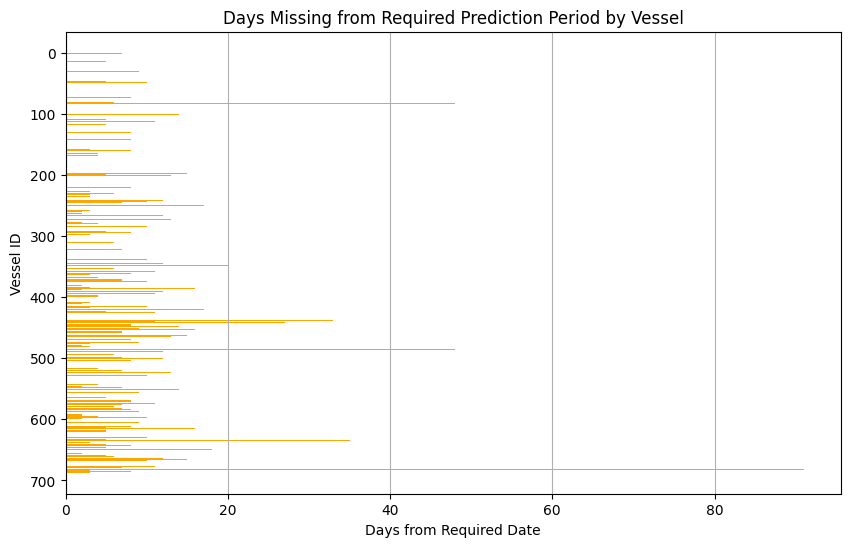

In [41]:
df_days_before_prediction = train.copy()
# Ensure 'time' column is in datetime format
df_days_before_prediction['time'] = pd.to_datetime(df_days_before_prediction['time'])


# Specify the year to append
current_year = 2024  # Change to the desired year

# Modify etaRaw to include the year
df_days_before_prediction['etaRaw'] = df_days_before_prediction['etaRaw'].apply(lambda x: f"{current_year}-{x}")


# Convert 'etaRaw' column to datetime
df_days_before_prediction['etaRaw'] = pd.to_datetime(df_days_before_prediction['etaRaw'], format='%Y-%m-%d %H:%M', errors='coerce')

# Define the start of the prediction period and calculate minimum required date
prediction_start_date = df_days_before_prediction['time'].max()
days_before_start = 0  # Set to the number of days you want before the start date
min_required_date = prediction_start_date 

# Get the last recorded date for each vessel along with `etaRaw`
vessel_last_dates = df_days_before_prediction.groupby('vesselId').agg({'time': 'max', 'etaRaw': 'last'}).reset_index()
vessel_last_dates.rename(columns={'time': 'last_train_time'}, inplace=True)

# Check the minimum required date
print("\nMinimum required date:")
print(min_required_date)

# Add a new column to indicate if etaRaw is before the minimum required date
vessel_last_dates['etaRaw_before_required'] = vessel_last_dates['etaRaw'] < min_required_date

# Calculate days missing from the required date
vessel_last_dates['days_from_required'] = (min_required_date - vessel_last_dates['last_train_time']).dt.days

# Add a new column to indicate if the data is before the required date
vessel_last_dates['before_required_date'] = vessel_last_dates['days_from_required'] > 1

# Separate vessels with incomplete data
vessels_with_incomplete_data = vessel_last_dates[vessel_last_dates['before_required_date']]

# Plot vessels with incomplete data
plt.figure(figsize=(10, 6))
plt.barh(vessels_with_incomplete_data['vesselId'], vessels_with_incomplete_data['days_from_required'], color='orange')
plt.xlabel('Days from Required Date')
plt.ylabel('Vessel ID')
plt.title('Days Missing from Required Prediction Period by Vessel')
plt.gca().invert_yaxis()  # Invert y-axis to have the vessel with the most missing days on top
plt.grid(axis='x')  # Add gridlines for better readability
plt.show()



In [42]:
# Define the minimum required date for predictions in the test set
min_required_date = test['time'].min()   # 5 days before the earliest test date
print(f"Minimum required date for predictions: {min_required_date}")

# Filter the schedules DataFrame based on the required date
schedules_filtered = schedules[~((schedules['sailingDate'] < min_required_date) & 
                                  (schedules['arrivalDate'] < min_required_date))]

# Get the last recorded date for each vessel in the training set
last_train_dates = train.groupby('vesselId')['time'].max().reset_index()
last_train_dates.rename(columns={'time': 'last_train_time'}, inplace=True)

# Print the filtered schedules for verification
# print("Filtered schedules:")
# print(schedules_filtered.head())

# Filter vessels that are in the test set
vessels_in_test = test['vesselId'].unique()
missing_days_df = last_train_dates[last_train_dates['vesselId'].isin(vessels_in_test)].copy()

# Calculate the days missing for each vessel from the required date
missing_days_df['days_missing'] = (min_required_date - missing_days_df['last_train_time']).dt.days

# Filter vessels missing a significant number of days (e.g., more than 2 days)
significant_gap_vessels = missing_days_df[missing_days_df['days_missing'] > 1]

# Print the vessels with significant gaps
print("Vessels in the test set missing significant data before prediction date:")
print(significant_gap_vessels[['vesselId', 'last_train_time', 'days_missing']])
print(f"Number of vessels with significant missing days: {len(significant_gap_vessels)}")

# Optional: If you want to check which vessels are in filtered schedules
vessels_in_filtered_schedules = schedules_filtered['vesselId'].unique()
print(f"Number of unique vessels in filtered schedules: {len(vessels_in_filtered_schedules)}")

# Step to find which significant gap vessels are in filtered schedules
vessels_in_gap_and_schedule = set(significant_gap_vessels['vesselId']).intersection(vessels_in_filtered_schedules)

# Create a DataFrame for common vessels with significant gaps in schedules
vessels_in_gap_and_schedule_df = significant_gap_vessels[significant_gap_vessels['vesselId'].isin(vessels_in_gap_and_schedule)]


# Print results
print("Vessels with significant gaps that are also in the filtered schedules:")
print(vessels_in_gap_and_schedule_df[['vesselId', 'last_train_time', 'days_missing']])
print(f"Number of vessels with significant missing days that are in schedules: {len(vessels_in_gap_and_schedule_df)}")

Minimum required date for predictions: 2024-05-08 00:03:16
Vessels in the test set missing significant data before prediction date:
     vesselId     last_train_time  days_missing
3           3 2024-04-26 13:29:25            11
30         30 2024-04-28 19:17:28             9
79         79 2024-04-28 04:45:55             9
80         80 2024-04-23 23:00:00            14
243       243 2024-04-27 21:40:48            10
282       282 2024-05-04 17:29:58             3
326       326 2024-05-04 15:17:17             3
344       344 2024-04-24 07:16:53            13
352       352 2024-04-29 00:05:23             8
358       358 2024-04-26 13:50:08            11
367       367 2024-04-30 07:08:07             7
378       378 2024-04-11 05:44:29            26
385       385 2024-04-30 22:02:25             7
417       417 2024-05-04 13:34:51             3
508       508 2024-05-03 22:32:02             4
528       528 2024-04-27 13:07:07            10
548       548 2024-04-30 18:39:21             7
564 

In [43]:

# Step to find which significant gap vessels are NOT in filtered schedules
vessels_in_gap_not_in_schedule = set(significant_gap_vessels['vesselId']).difference(vessels_in_filtered_schedules)

# Create a DataFrame for vessels with significant gaps that are not in the schedules
vessels_in_gap_not_in_schedule_df = significant_gap_vessels[significant_gap_vessels['vesselId'].isin(vessels_in_gap_not_in_schedule)]

# Print results
print("Vessels with significant gaps that are NOT in the filtered schedules:")
print(vessels_in_gap_not_in_schedule_df[['vesselId', 'last_train_time', 'days_missing']])
print(f"Number of vessels with significant missing days that are NOT in schedules: {len(vessels_in_gap_not_in_schedule_df)}")

Vessels with significant gaps that are NOT in the filtered schedules:
     vesselId     last_train_time  days_missing
30         30 2024-04-28 19:17:28             9
80         80 2024-04-23 23:00:00            14
326       326 2024-05-04 15:17:17             3
344       344 2024-04-24 07:16:53            13
352       352 2024-04-29 00:05:23             8
358       358 2024-04-26 13:50:08            11
378       378 2024-04-11 05:44:29            26
385       385 2024-04-30 22:02:25             7
508       508 2024-05-03 22:32:02             4
528       528 2024-04-27 13:07:07            10
587       587 2024-04-28 23:44:44             9
615       615 2024-04-21 08:15:03            16
632       632 2024-04-29 18:08:30             8
647       647 2024-04-26 22:05:53            11
656       656 2024-05-05 03:27:01             2
675       675 2024-04-12 06:09:24            25
Number of vessels with significant missing days that are NOT in schedules: 16


In [44]:
schedules_filtered.head()

,vesselId,shippingLineId,shippingLineName,arrivalDate,sailingDate,portName,portId,portLatitude,portLongitude
8,616.0,0,Hoegh Autoliners,2024-06-02 10:00:00,2024-06-04 10:00:00,Port of Durban,170.0,-29.881111,31.027222
9,616.0,0,Hoegh Autoliners,2024-05-18 22:15:00,2024-05-18 22:30:00,Port of Sohar,243.0,24.378333,56.740556
10,616.0,0,Hoegh Autoliners,2024-05-16 19:00:00,2024-05-16 22:00:00,Port of Shuaiba,509.0,29.044722,48.159722
11,616.0,0,Hoegh Autoliners,2024-07-07 10:00:00,2024-07-08 08:30:00,Port of Jacksonville,41.0,30.380833,-81.564444
13,616.0,0,Hoegh Autoliners,2024-06-23 10:00:00,2024-06-24 10:00:00,Port of Kingston,306.0,17.981667,-76.829444


In [45]:
print(train.head())
print(train.info())
print("Number of missing values in each column:\n", train.isnull().sum())

                 time    cog   sog  rot  heading  navstat       etaRaw  \
0 2024-01-01 00:00:25  284.0   0.7    0       88        0  01-09 23:00   
1 2024-01-01 00:00:36  109.6   0.0   -6      347        1  12-29 20:00   
2 2024-01-01 00:01:45  111.0  11.0    0      112        0  01-02 09:00   
3 2024-01-01 00:03:11   96.4   0.0    0      142        1  12-31 20:00   
4 2024-01-01 00:03:51  214.0  19.7    0      215        0  01-25 12:00   

   latitude  longitude  vesselId  portId  latitude_port  longitude_port  \
0 -34.74370  -57.85130         0       0       -33.5875      -71.618889   
1   8.89440  -79.47939         1       1         8.9670      -79.533000   
2  39.19065  -76.47567         2       2        39.2325      -76.558889   
3 -34.41189  151.02067         3       3       -34.4625      150.899444   
4  35.88379   -5.91636         4       4        35.7830       -5.817000   

   length  shippingLineId  breadth     GT  
0  199.00               9    32.00  57718  
1  199.97       

In [46]:
def create_five_day_windows(df):
    # Ensure that 'time' column is in datetime format
    df['time'] = pd.to_datetime(df['time'])
    
    # Sort data to ensure time sequence within each vessel
    df = df.sort_values(by=['vesselId', 'time']).reset_index(drop=True)

    windows = []

    for vessel_id, group in df.groupby('vesselId'):
        group = group.sort_values(by='time')
        unique_dates = group['time'].dt.date.unique()

        # Start index for the window
        start_idx = 0
        
        while start_idx < len(unique_dates):
            # Determine the end index for the current window, allowing up to 5 days
            end_idx = min(start_idx + 5, len(unique_dates))  # Allow up to 5 days
            start_date = unique_dates[start_idx]
            end_date = unique_dates[end_idx - 1]  # Last day in the current window

            # Select data within the current window
            window = group[(group['time'].dt.date >= start_date) & (group['time'].dt.date <= end_date)]

            # If there are no rows in the window, we can skip to the next unique date
            if len(window) == 0:
                start_idx += 1
                continue
            
            # Reference row: the first row in the window
            reference_row = window.iloc[0]

            # Append each row in this window with reference features from the first row
            for _, row in window.iterrows():
                windows.append({
                    'vesselId': row['vesselId'],
                    'time': row['time'],
                    'latitude': row['latitude'],
                    'longitude': row['longitude'],
                    'latitude_port': row['latitude_port'],
                    'longitude_port': row['longitude_port'],
                    'cog_sin': row['cog_sin'],
                    'cog_cos': row['cog_cos'],
                    'cog': row['cog'],
                    'sog': row['sog'],
                    'rot': row['rot'],
                    'under_way': row['under_way'],
                    'length': row['length'],
                    'breadth': row['breadth'],
                    'GT': row['GT'],
                    # Features based on the first row in the window
                    'latitude_first': reference_row['latitude'],
                    'longitude_first': reference_row['longitude'],
                    'cog_sin_first': reference_row['cog_sin'],
                    'cog_cos_first': reference_row['cog_cos'],
                    'sog_first': reference_row['sog'],
                    # 'rot_first': reference_row['rot'],
                    'under_way_first': reference_row['under_way'],
                    'time_since_start': (row['time'] - reference_row['time']).total_seconds()
                })

            # Move to the next start index (no overlap)
            start_idx += 5  # Increment by 5 to avoid overlap, allowing for the next window to start after the current one
            
    return pd.DataFrame(windows)


In [47]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)) 
    r = 6371  # Radius of Earth in kilometers
    return r * c  # Distance in kilometers

In [48]:
from shapely.geometry import MultiPoint
from pyproj import Transformer

def calculate_area_covered(df, group_col='vesselId'):
    df['area_covered'] = 0.0
    transformer = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)  # WGS84 to Web Mercator for area
    
    for vessel_id, group in df.groupby(group_col):
        coords = group[['longitude', 'latitude']].dropna().values
        if len(coords) >= 3:
            # Transform to Cartesian coordinates
            x_coords, y_coords = transformer.transform(coords[:, 0], coords[:, 1])
            projected_coords = list(zip(x_coords, y_coords))
            
            # Calculate area of the convex hull
            convex_hull = MultiPoint(projected_coords).convex_hull
            area = convex_hull.area  # area in square meters
            area_km2 = area / 1e6  # Convert to square kilometers
        else:
            area_km2 = 0
        
        df.loc[group.index, 'area_covered'] = area_km2

    return df


### Feature engineering 

In [49]:
def feature_engineering(train):
    train = train.copy()
    train = train.sort_values(by=['vesselId', 'time']).reset_index(drop=True)

    # # Handle NaNs
    # train[['latitude', 'longitude', 'cog', 'time']] = (
    #     train.groupby('vesselId')[['latitude', 'longitude', 'cog', 'time']].apply(lambda x: x.ffill().bfill())
    # ).reset_index(drop=True)

    features = pd.DataFrame()
    features['vesselId'] = train['vesselId']
    features['time'] = train['time'] 
    features['latitude'] = train['latitude']
    features['longitude'] = train['longitude']
    features['cog'] = train['cog']
    features['sog'] = train['sog']
    features['rot'] = train['rot']
    features['under_way'] = train['navstat'].isin([0, 8]).astype(int)
    features['cog_rad'] = np.radians(features['cog'])
    features['cog_sin'] = np.sin(features['cog_rad'])
    features['cog_cos'] = np.cos(features['cog_rad'])
    features['length'] = train['length']
    features['breadth'] = train['breadth']
    features['GT'] = train['GT']
    features['latitude_port'] = train['latitude_port']
    features['longitude_port'] = train['longitude_port']
    
    
    features = create_five_day_windows(features)
    print("Features columns after window creation:", features.columns)

    
    # # Calculate area covered incrementally
    # features['area_covered'] = features.groupby('vesselId').apply(
    #     lambda group: incremental_convex_hull(group)
    # ).explode().reset_index(drop=True)

    # # Convert area to numeric
    # features['area_covered'] = pd.to_numeric(features['area_covered'], errors='coerce')
    features = calculate_area_covered(features)

    features['latitude_port'] = train['latitude_port']
    features['longitude_port'] = train['longitude_port']

    features['distance_to_port'] = haversine(features['latitude'], features['longitude'], 
                                              features['latitude_port'], features['longitude_port'])
    
    features['time_numeric'] = features['time'].astype('int64') // 10**9


    # #Calculate area covered incrementally
    # features['area_covered'] = features.groupby('vesselId').apply(incremental_convex_hull).reset_index(drop=True)

    # # Convert area to numeric
    # features['area_covered'] = pd.to_numeric(features['area_covered'], errors='coerce')
    
    # features['time_diff'] = features.groupby('vesselId')['time'].diff().dt.total_seconds().fillna(0)

    # # Calculate future positions
    # future_positions = features.apply(lambda row: future_position(
    #     row['latitude'], row['longitude'], row['cog'], row['sog'], row['time_diff']), axis=1)

    # features['future_latitude'], features['future_longitude'] = zip(*future_positions)
    
    # features['area_covered'] = features.apply(lambda row: calculate_convex_hull_area(
    #     features[(features['vesselId'] == row['vesselId']) & (features['time'] <= row['time'])]['latitude'].tolist(),
    #     features[(features['vesselId'] == row['vesselId']) & (features['time'] <= row['time'])]['longitude'].tolist()), axis=1)

    # Calculate cumulative area covered for each vessel
    # features['cumulative_area_covered'] = features.groupby('vesselId')['area_covered'].cumsum()
 
    features['month'] = features['time'].dt.month
    features['day'] = features['time'].dt.day
    features['hour'] = features['time'].dt.hour
    features['minute'] = features['time'].dt.minute
    # features['day_of_week'] = features['time'].dt.dayofweek

    return features

training_data = train
features = feature_engineering(training_data)

KeyboardInterrupt: 

In [ ]:
train_features = features.copy()
train_features.info()
train_features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520450 entries, 0 to 1520449
Data columns (total 29 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   vesselId          1520450 non-null  int64         
 1   time              1520450 non-null  datetime64[ns]
 2   latitude          1520450 non-null  float64       
 3   longitude         1520450 non-null  float64       
 4   latitude_port     1520450 non-null  float64       
 5   longitude_port    1520450 non-null  float64       
 6   cog_sin           1520450 non-null  float64       
 7   cog_cos           1520450 non-null  float64       
 8   cog               1520450 non-null  float64       
 9   sog               1520450 non-null  float64       
 10  rot               1520450 non-null  int64         
 11  under_way         1520450 non-null  int64         
 12  length            1520450 non-null  float64       
 13  breadth           1520450 non-null  float6

,vesselId,time,latitude,longitude,latitude_port,longitude_port,cog_sin,cog_cos,cog,sog,...,sog_first,under_way_first,time_since_start,area_covered,distance_to_port,time_numeric,month,day,hour,minute
0,0,2024-01-01 00:00:25,-34.74370,-57.85130,-33.5875,-71.618889,-0.970296,0.241922,284.0,0.7,...,0.7,1,0.0,1.781496e+08,1272.179414,1704067225,1,1,0,0
1,0,2024-01-01 06:09:08,-35.16787,-56.77210,-33.5875,-71.618889,0.998806,-0.048850,92.8,14.2,...,0.7,1,22123.0,1.781496e+08,1372.504428,1704089348,1,1,6,9
2,0,2024-01-01 06:38:19,-35.16863,-56.63185,-33.5875,-71.618889,0.999962,-0.008727,90.5,14.3,...,0.7,1,23874.0,1.781496e+08,1385.239318,1704091099,1,1,6,38
3,0,2024-01-01 06:58:55,-35.16805,-56.53190,-33.5875,-71.618889,0.999507,0.031411,88.2,14.3,...,0.7,1,25110.0,1.781496e+08,1394.309141,1704092335,1,1,6,58
4,0,2024-01-01 07:15:56,-35.16715,-56.45306,-33.5875,-71.618889,0.999560,0.029666,88.3,12.3,...,0.7,1,26131.0,1.781496e+08,1401.461476,1704093356,1,1,7,15


In [ ]:
# nan_values = train_features.isnull().sum()
# print(nan_values)


# Drop the columns 'time' and 'rot'
train_features= train_features.drop(columns=['time'])

nan_values = train_features.isnull().sum()
print(nan_values)

vesselId            0
latitude            0
longitude           0
latitude_port       0
longitude_port      0
cog_sin             0
cog_cos             0
cog                 0
sog                 0
rot                 0
under_way           0
length              0
breadth             0
GT                  0
latitude_first      0
longitude_first     0
cog_sin_first       0
cog_cos_first       0
sog_first           0
under_way_first     0
time_since_start    0
area_covered        0
distance_to_port    0
time_numeric        0
month               0
day                 0
hour                0
minute              0
dtype: int64


In [ ]:
train_features = train_features.dropna()



In [ ]:
train_features.tail()

,vesselId,latitude,longitude,latitude_port,longitude_port,cog_sin,cog_cos,cog,sog,rot,...,sog_first,under_way_first,time_since_start,area_covered,distance_to_port,time_numeric,month,day,hour,minute
1520445,687,37.06484,144.66435,38.413333,141.265833,0.872069,0.489382,60.7,16.0,0,...,16.9,1,14400.0,9.932482e+06,334.320268,1714796097,5,4,4,14
1520446,687,37.11041,144.76165,38.413333,141.265833,0.849893,0.526956,58.2,15.7,0,...,16.9,1,15623.0,9.932482e+06,339.711487,1714797320,5,4,4,35
1520447,687,37.15745,144.85164,38.413333,141.265833,0.845262,0.534352,57.7,15.4,0,...,16.9,1,16806.0,9.932482e+06,344.639097,1714798503,5,4,4,55
1520448,687,37.20409,144.94732,38.413333,141.265833,0.854459,0.519519,58.7,15.1,0,...,16.9,1,18072.0,9.932482e+06,350.224492,1714799769,5,4,5,16
1520449,687,37.22231,144.98452,38.413333,141.265833,0.864275,0.503020,59.8,14.9,0,...,16.9,1,18576.0,9.932482e+06,352.440469,1714800273,5,4,5,24


In [ ]:
def find_last_features(features):
    # Assuming that the last row for every vesselId is the most recent
    last_features = features.groupby('vesselId').last().reset_index()
    return last_features

last_features = find_last_features(train_features)
# last_features.drop(columns=['DWT']) 
last_features.head(10)

,vesselId,latitude,longitude,latitude_port,longitude_port,cog_sin,cog_cos,cog,sog,rot,...,sog_first,under_way_first,time_since_start,area_covered,distance_to_port,time_numeric,month,day,hour,minute
0,0,34.57936,128.99926,35.109444,129.059444,-0.662620,-0.748956,221.5,15.5,0,...,0.0,0,1254344.0,1.781496e+08,59.197981,1714567317,5,1,12,41
1,1,1.24460,103.39997,51.498889,-2.712222,-0.818150,0.575005,305.1,15.7,11,...,0.0,0,35620.0,9.016407e+07,11003.719371,1714471921,4,30,10,12
2,2,18.13873,-69.74863,18.475278,-69.881111,0.069756,-0.997564,176.0,0.4,0,...,15.5,1,427475.0,1.611915e+08,39.950410,1715126342,5,7,23,59
3,3,41.64055,143.29942,42.988611,144.353611,0.999123,0.041876,87.6,14.4,0,...,9.7,1,455585.0,1.580457e+07,173.151349,1714138165,4,26,13,29
4,4,26.58710,121.27831,27.583000,120.450000,0.630676,0.776046,39.1,12.7,0,...,0.0,0,562766.0,1.485581e+08,137.794398,1715084919,5,7,12,28
5,5,24.92350,-109.76272,25.594167,-109.054444,0.642788,0.766044,40.0,18.9,0,...,14.4,1,127154.0,4.859693e+04,103.123874,1715126293,5,7,23,58
6,6,41.21686,12.81621,40.900000,12.967000,0.837719,-0.546102,123.1,19.6,0,...,15.9,1,353230.0,1.381453e+06,37.432947,1715126229,5,7,23,57
7,7,1.26255,104.24250,1.169722,104.020000,0.994338,0.106264,83.9,13.8,0,...,15.9,1,1237572.0,1.071243e+07,26.802585,1714915290,5,5,13,21
8,8,-43.53785,172.83522,-43.606111,172.716111,-0.625243,0.780430,321.3,0.1,0,...,0.0,0,171431.0,7.194421e+07,12.234717,1715125954,5,7,23,52
9,9,35.46923,139.68347,35.436389,139.667778,0.017452,-0.999848,179.0,0.0,0,...,10.4,1,247300.0,9.514700e+07,3.918617,1715126226,5,7,23,57


### Train the model

In [ ]:
# # Define features and target
y = train_features[['latitude', 'longitude']]  
X = train_features.drop(columns=[ 'vesselId', 'latitude', 'longitude','latitude_port', 'longitude_port','minute', 'hour', 'month', 'cog', 'day']) #'minute', 'hour', 'month', 'vesselId'
X.head()

,cog_sin,cog_cos,sog,rot,under_way,length,breadth,GT,latitude_first,longitude_first,cog_sin_first,cog_cos_first,sog_first,under_way_first,time_since_start,area_covered,distance_to_port,time_numeric
0,-0.970296,0.241922,0.7,0,1,199.0,32.0,57718,-34.7437,-57.8513,-0.970296,0.241922,0.7,1,0.0,1.781496e+08,1272.179414,1704067225
1,0.998806,-0.048850,14.2,0,1,199.0,32.0,57718,-34.7437,-57.8513,-0.970296,0.241922,0.7,1,22123.0,1.781496e+08,1372.504428,1704089348
2,0.999962,-0.008727,14.3,0,1,199.0,32.0,57718,-34.7437,-57.8513,-0.970296,0.241922,0.7,1,23874.0,1.781496e+08,1385.239318,1704091099
3,0.999507,0.031411,14.3,0,1,199.0,32.0,57718,-34.7437,-57.8513,-0.970296,0.241922,0.7,1,25110.0,1.781496e+08,1394.309141,1704092335
4,0.999560,0.029666,12.3,0,1,199.0,32.0,57718,-34.7437,-57.8513,-0.970296,0.241922,0.7,1,26131.0,1.781496e+08,1401.461476,1704093356


In [ ]:
best_model = RandomForestRegressor(max_depth=25, random_state=42, n_jobs=-1)

# # Define the parameter grid for Random Forest
# param_grid = {
#     'n_estimators': [300, 500, 1000],            # Number of trees in the forest
#     'max_depth': [10, 25, 50, None],             # Maximum depth of the tree
#     'min_samples_split': [2, 5],           # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2],            # Minimum number of samples required to be at a leaf node
#     'max_features': ['auto', 'sqrt'],      # The number of features to consider when looking for the best split
#     'bootstrap': [True, False]             # Whether bootstrap samples are used when building trees
# }

# # # Perform Randomized Search
# random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
#                                    n_iter=20, scoring='neg_mean_squared_error', cv=5, verbose=1, random_state=42)
# random_search.fit(X, y)

# best_model = random_search.best_estimator_

# # Output the best parameters and score
# print(f"Best parameters: {random_search.best_params_}")
# print(f"Best score (negative mean squared error): {-random_search.best_score_}")



# Configure and fit XGBoost model with GPU support
# best_model = RandomForestRegressor(
#     # tree_method='gpu_hist',  # Ensure GPU method is used
#     # n_estimators=1000,       # Increase number of estimators
#     max_depth=25,            # Increase tree depth
#     random_state=42     # Set learning rate
# )

# Fit the model
# best_model.fit(X_train, y_train)

# # Evaluate the model (optional)
# preds = model.predict(X_test)

# best_model = xgb.XGBRegressor()

# Fit the model
best_model.fit(X, y)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\ingvi\ml\venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
33 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ingvi\ml\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ingvi\ml\venv\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ingvi\ml\venv\Lib\site-packages\sklearn\ensemble\_forest.py", line 489, in fit
    trees = Parallel(
        

In [ ]:

# Step 1: Get feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame to display feature importances
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Step 2: Print feature importances
print("Feature Importances:")
print(features_df)

Feature Importances:
             Feature  Importance
9    longitude_first    0.744853
14  time_since_start    0.115211
8     latitude_first    0.082497
15      area_covered    0.015593
16  distance_to_port    0.007766
10     cog_sin_first    0.007064
11     cog_cos_first    0.006420
17      time_numeric    0.005156
7                 GT    0.003783
12         sog_first    0.003044
5             length    0.002589
0            cog_sin    0.002118
6            breadth    0.001900
2                sog    0.001189
1            cog_cos    0.000528
13   under_way_first    0.000196
3                rot    0.000046
4          under_way    0.000045


In [ ]:
X.head()
X.columns

Index(['cog_sin', 'cog_cos', 'sog', 'rot', 'under_way', 'length', 'breadth',
       'GT', 'latitude_first', 'longitude_first', 'cog_sin_first',
       'cog_cos_first', 'sog_first', 'under_way_first', 'time_since_start',
       'area_covered', 'distance_to_port', 'time_numeric'],
      dtype='object')

Find out where vessels that are missing significant days are going 

In [ ]:
# # # Confirm unique vesselIds in vessels_in_gap_in_schedule
# print("Unique vesselIds in vessels_in_gap_in_schedule:")
# print(vessels_in_gap_and_schedule_df['vesselId'].unique())
# print(f"Count of unique vesselIds: {len(vessels_in_gap_and_schedule_df['vesselId'].unique())}")

Unique vesselIds in vessels_in_gap_in_schedule:
[  3  79 243 282 367 417 548 564 574 679]
Count of unique vesselIds: 10


In [ ]:
# matching_vessels = set(last_features['vesselId']).intersection(set(vessels_in_gap_and_schedule_df['vesselId']))
# print(f"Number of matching vesselIds: {len(matching_vessels)}")


Number of matching vesselIds: 10


In [ ]:
# 'matching_vessels = set(last_features['vesselId']).intersection(set(vessels_in_gap_and_schedule_df['vesselId']))
# print(f"Number of matching vesselIds: {len(matching_vessels)}")

# # Step 2: Filter the schedules for matching vessels only
# matched_schedules = schedules_filtered[schedules_filtered['vesselId'].isin(matching_vessels)]

# # Step 3: Define a function to get the next n scheduled occurrences
# def get_next_n_schedules(df, n=1):
#     next_schedules = []
#     for vessel_id, group in df.groupby('vesselId'):
#         # Sort by 'arrivalDate' to ensure future schedule order
#         group = group.sort_values(by='arrivalDate')
        
#         # Get the next n occurrences
#         future_occurrences = group.head(n)
#         next_schedules.append(future_occurrences)
    
#     # Concatenate all schedules into one DataFrame
#     return pd.concat(next_schedules)

# # # Get the next 3 occurrences for each vessel
# # n_occurrences = 10
# # next_schedules_df = get_next_n_schedules(schedules_filtered, n=n_occurrences)

# # # Reset index if necessary
# # next_schedules_df.reset_index(drop=True, inplace=True)

# # print(next_schedules_df)

# # Get the next 3 occurrences for each vessel in matching vessels
# n_occurrences = 1
# next_schedules_df = get_next_n_schedules(matched_schedules, n=n_occurrences)

# # Reset index if needed
# next_schedules_df.reset_index(drop=True, inplace=True)

# print(next_schedules_df)


In [ ]:
# import numpy as np
# import pandas as pd
# from geopy.distance import geodesic

# # Step 1: Get matching vessel IDs
# matching_vessels = set(last_features['vesselId']).intersection(set(vessels_in_gap_and_schedule_df['vesselId']))
# print(f"Number of matching vesselIds: {len(matching_vessels)}")

# # Step 2: Filter last_features to include only matching vessels
# last_features_matching = last_features[last_features['vesselId'].isin(matching_vessels)]


# # Step 3: Filter the schedules for the matching vessels only
# matching_schedules = next_schedules_df[next_schedules_df['vesselId'].isin(matching_vessels)]

# # Step 4: Merge the schedules with last_features_matching based on vesselId to get the next scheduled port
# last_features_matching = pd.merge(
#     last_features_matching,
#     matching_schedules[['vesselId', 'portLatitude', 'portLongitude']],
#     on='vesselId', how='left'
# )
# print(last_features_matching.columns)
# last_features_matching.rename(columns={'portLatitude_x': 'portLatitude', 'portLongitude_x': 'portLongitude'}, inplace=True)


# # Step 5: Calculate distance to the next scheduled port only for vessels that have a port scheduled
# def haversine(lat1, lon1, lat2, lon2):
#     """Calculate the distance between two points on the Earth"""
#     return geodesic((lat1, lon1), (lat2, lon2)).kilometers

# # Apply haversine formula to calculate the distance to the next port for matching vessels only
# last_features_matching['distance_to_port'] = last_features_matching.apply(
#     lambda row: haversine(row['latitude'], row['longitude'], row['portLatitude'], row['portLongitude'])
#     if pd.notnull(row['portLatitude']) and pd.notnull(row['portLongitude']) else np.nan, axis=1
# )

# # Now `last_features_matching` contains only the matching vessels with updated ports and distance to the next scheduled port
# print(last_features_matching)

# # Step 6: Merge back into the original last_features to update distance_to_port for matching vessels
# last_features_updated = pd.merge(
#     last_features,
#     last_features_matching[['vesselId', 'distance_to_port', 'portName', 'portLatitude', 'portLongitude']],
#     on='vesselId', how='left'
# )

# # Now `last_features_updated` will have the updated values for matching vessels, and NaN for non-matching vessels
# print(last_features_updated)


Vessels that are not in schedule but are missing days, modify the last feature 

In [ ]:
# last_features_gap = last_features[last_features['vesselId'].isin(vessels_in_gap_not_in_schedule_df['vesselId'])].copy()
# last_features_gap.head()

# last_features_gap['under_way'] = 0  # Stationary mode
# last_features_gap['sog'] = 0        # Speed over ground to 0
# last_features_gap['rot'] = 0        # Rate of turn to 0
# last_features_gap['cog'] = 0        # Optional: course over ground to 0
# last_features_gap['cog_sin'] = 0    # Sine of course to 0
# last_features_gap['cog_cos'] = 1    # Cosine of course to 1
# last_features_gap['distance_to_port'] = 0
# last_features_gap['time_since_start'] = 0


# # Align with the maximum time and date fields in last_features
# last_features_gap['day'] = 6 #sunday before 8th of May 
# last_features_gap['month'] = last_features['month'].max()
# # last_features_gap['minute'] = last_features['minute'].max()
# last_features_gap = last_features_gap.drop(columns=['year'], errors='ignore')

# # # Explicitly cast each column in last_features_gap to match last_features data types
# # for column in last_features_gap.columns:
# #     if column in last_features.columns:
# #         last_features_gap[column] = last_features_gap[column].astype(last_features[column].dtype)


# last_features_gap.columns
# last_features_gap.head()

,vesselId,latitude,longitude,latitude_port,longitude_port,cog_sin,cog_cos,cog,sog,rot,...,sog_first,under_way_first,time_since_start,area_covered,distance_to_port,time_numeric,month,day,hour,minute
30,30,35.33234,142.69115,36.425278,140.621111,0,1,0,0,0,...,8.5,1,0,9.959179e+07,0,1714331848,5,6,19,17
80,80,38.77321,118.79824,38.950000,118.533000,0,1,0,0,0,...,13.4,1,0,1.611290e+08,0,1713913200,5,6,23,0
326,326,35.83590,14.62925,35.826111,14.545833,0,1,0,0,0,...,5.4,0,0,4.247407e+06,0,1714835837,5,6,15,17
344,344,34.36324,-120.54771,34.149167,-119.207778,0,1,0,0,0,...,2.6,1,0,9.464106e+07,0,1713943013,5,6,7,16
352,352,-33.79642,17.46789,38.492778,-8.835556,0,1,0,0,0,...,16.5,1,0,1.596931e+08,0,1714349123,5,6,0,5


In [ ]:
# # Ensure columns in last_features_gap match data types of last_features
# # Ensure compatibility by casting last_features_gap columns to the same dtype as last_features
# for column in last_features.columns:
#     if column in last_features_gap.columns:
#         print(f"Casting {column} to {last_features[column].dtype}")
#         last_features_gap[column] = last_features_gap[column].astype(last_features[column].dtype)


# # Now proceed to update last_features
# last_features.update(last_features_gap)

# # Now proceed with the update as before
# last_features.set_index('vesselId', inplace=True)
# last_features_gap.set_index('vesselId', inplace=True)
# last_features.update(last_features_gap)

# # Reset index if needed for subsequent operations
# last_features.reset_index(inplace=True)
# last_features_gap.reset_index(inplace=True)

# # Check a sample to verify the updates have been applied
# print(last_features[last_features['vesselId'].isin(vessels_in_gap_not_in_schedule_df['vesselId'])].head())


Casting vesselId to int64
Casting latitude to float64
Casting longitude to float64
Casting latitude_port to float64
Casting longitude_port to float64
Casting cog_sin to float64
Casting cog_cos to float64
Casting cog to float64
Casting sog to float64
Casting rot to int64
Casting under_way to int64
Casting length to float64
Casting breadth to float64
Casting GT to int64
Casting latitude_first to float64
Casting longitude_first to float64
Casting cog_sin_first to float64
Casting cog_cos_first to float64
Casting sog_first to float64
Casting under_way_first to int32
Casting time_since_start to float64
Casting area_covered to float64
Casting distance_to_port to float64
Casting time_numeric to int64
Casting month to int32
Casting day to int32
Casting hour to int32
Casting minute to int32
     vesselId  latitude  longitude  latitude_port  longitude_port  cog_sin  \
30         30  35.33234  142.69115      36.425278      140.621111      0.0   
80         80  38.77321  118.79824      38.950000   

C:\Users\ingvi\AppData\Local\Temp\ipykernel_18872\2154908180.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 1 1 0 1 1 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1
 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 0
 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1
 0 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0
 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0
 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 1 1 1 1 1
 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 1 0 0 0
 1 1 1 0 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 1

In [ ]:
# Display rows with any NaN values in last_features
nan_rows = last_features[last_features.isna().any(axis=1)]
print(nan_rows)

# Alternatively, get a summary of NaNs in each column
nan_summary = last_features.isna().sum()
print("Summary of NaN values per column:")
print(nan_summary)


Empty DataFrame
Columns: [vesselId, latitude, longitude, latitude_port, longitude_port, cog_sin, cog_cos, cog, sog, rot, under_way, length, breadth, GT, latitude_first, longitude_first, cog_sin_first, cog_cos_first, sog_first, under_way_first, time_since_start, area_covered, distance_to_port, time_numeric, month, day, hour, minute]
Index: []

[0 rows x 28 columns]
Summary of NaN values per column:
vesselId            0
latitude            0
longitude           0
latitude_port       0
longitude_port      0
cog_sin             0
cog_cos             0
cog                 0
sog                 0
rot                 0
under_way           0
length              0
breadth             0
GT                  0
latitude_first      0
longitude_first     0
cog_sin_first       0
cog_cos_first       0
sog_first           0
under_way_first     0
time_since_start    0
area_covered        0
distance_to_port    0
time_numeric        0
month               0
day                 0
hour                0
minut

In [ ]:
### Prepare test data for predictions
expected_features = X.columns 

def prepare_test_for_predictions(test, last_features):
    test = test.copy()
    prepared_test = pd.DataFrame()

    # Create a time column in last features
    last_features['year'] = 2024
    last_features['time'] = pd.to_datetime(
        last_features[['year', 'month', 'day', 'hour', 'minute']]
    )

    # Add the columns vesselId and time
    prepared_test['vesselId'] = test['vesselId']
    prepared_test['time'] = test['time']
    print(prepared_test.head())
    # For each vessel, add the last seen features to the prepared test
    prepared_test = prepared_test.merge(last_features, on='vesselId', how='left', suffixes=('', '_last'))

    print(prepared_test.head())

    # Move the last_features to the reference row in the windows
    prepared_test['latitude_first'] = prepared_test['latitude']
    prepared_test['longitude_first'] = prepared_test['longitude']
    prepared_test['cog_sin_first'] = prepared_test['cog_sin']
    prepared_test['cog_cos_first'] = prepared_test['cog_cos']  # Fixed typo here
    prepared_test['sog_first'] = prepared_test['sog']
    prepared_test['under_way_first'] = prepared_test['under_way']
    prepared_test['time_since_start'] = (prepared_test['time'] - prepared_test['time_last']).dt.total_seconds()

    # Split the time column into month, day, hour, minute
    prepared_test['month'] = test['time'].dt.month
    prepared_test['day'] = test['time'].dt.day
    prepared_test['hour'] = test['time'].dt.hour
    prepared_test['minute'] = test['time'].dt.minute

    prepared_test['length'] = prepared_test['length']  # Ensure this column exists in 'prepared_test'
    prepared_test['breadth'] = prepared_test['breadth']  # Ensure this column exists in 'prepared_test'
    # prepared_test['DWT'] = prepared_test['DWT']  # Ensure this column exists in 'prepared_test'
    prepared_test['GT'] = prepared_test['GT']  # Ensure this column exists in 'prepared_test'
    # prepared_test['vessel_deep_sea'] = prepared_test['vessel_deep_sea']  # Ensure this column exists in 'prepared_test'
    prepared_test['rot'] = prepared_test['rot']  # Ensure this column exists in 'prepared_test'
    # prepared_test['day_of_week'] = prepared_test['time'].dt.dayofweek  # Added missing day_of_week calculation
    prepared_test['time_numeric'] = prepared_test['time'].astype('int64') // 10**9

    # Drop the columns that are no longer needed
    prepared_test.drop(['time', 'time_last', 'year'], axis=1, inplace=True)

    # Reorder the columns
    for column in expected_features:
        if column not in prepared_test.columns:
            prepared_test[column] = 0  # Assign a default value (0) for missing columns

    # Reorder columns to match expected_features
    prepared_test = prepared_test[expected_features]

    return prepared_test

# Prepare the test DataFrame
test_df = prepare_test_for_predictions(test, last_features)
# test_df.drop(['vesselId'])
test_df.head(10)

   vesselId                time
0       412 2024-05-08 00:03:16
1       372 2024-05-08 00:06:17
2       180 2024-05-08 00:10:02
3         8 2024-05-08 00:10:34
4        64 2024-05-08 00:12:27
   vesselId                time  latitude  longitude  latitude_port  \
0       412 2024-05-08 00:03:16  31.14647  -81.49789      31.140556   
1       372 2024-05-08 00:06:17  14.81694  120.29625      14.808333   
2       180 2024-05-08 00:10:02  38.27895   10.78280      42.098889   
3         8 2024-05-08 00:10:34 -43.53785  172.83522     -43.606111   
4        64 2024-05-08 00:12:27  48.53320   -6.12003      48.380556   

   longitude_port   cog_sin   cog_cos    cog   sog  ...  time_since_start  \
0      -81.496667  0.006981 -0.999976  179.6   0.0  ...          170258.0   
1      120.279444  0.417867  0.908508   24.7   0.0  ...           27619.0   
2       11.780833  0.139173  0.990268    8.0  18.7  ...          341549.0   
3      172.716111 -0.625243  0.780430  321.3   0.1  ...          171431.0

,cog_sin,cog_cos,sog,rot,under_way,length,breadth,GT,latitude_first,longitude_first,cog_sin_first,cog_cos_first,sog_first,under_way_first,time_since_start,area_covered,distance_to_port,time_numeric
0,0.006981,-0.999976,0.0,0,0,230.00,32.0,74255,31.14647,-81.49789,0.006981,-0.999976,0.0,0,916.0,2.509906e+08,0.667828,1715125696
1,0.417867,0.908508,0.0,0,0,124.00,20.0,9984,14.81694,120.29625,0.417867,0.908508,0.0,0,557.0,6.489569e+06,2.044479,1715126236
2,0.139173,0.990268,18.7,0,1,186.00,27.0,25995,38.27895,10.78280,0.139173,0.990268,18.7,1,662.0,2.370752e+05,433.125763,1715126348
3,-0.625243,0.780430,0.1,0,0,183.00,30.2,45959,-43.53785,172.83522,-0.625243,0.780430,0.1,0,1114.0,7.194421e+07,12.234717,1715125954
4,-0.933580,0.358368,0.3,0,0,182.00,31.0,46800,48.53320,-6.12003,-0.933580,0.358368,0.3,0,1287.0,2.650286e+06,122.548884,1715125889
5,0.777146,0.629320,0.0,0,0,191.00,21.0,23128,51.35306,3.19241,0.777146,0.629320,0.0,0,1111.0,1.085486e+06,2.120074,1715126064
6,-0.299041,0.954240,0.0,0,0,214.00,32.0,56738,43.34995,-8.50739,-0.299041,0.954240,0.0,0,1078.0,3.120969e+07,9.557714,1715126161
7,0.268920,0.963163,0.0,0,0,199.97,36.5,75283,51.31666,3.22506,0.268920,0.963163,0.0,0,1121.0,1.674597e+08,2.519690,1715126199
8,-0.500000,0.866025,0.0,0,0,125.00,18.0,11591,40.84712,29.29052,-0.500000,0.866025,0.0,0,1083.0,6.935110e+06,44.040041,1715126220
9,-0.464842,-0.885394,0.1,0,0,199.00,36.0,65255,38.47378,15.91582,-0.464842,-0.885394,0.1,0,1114.0,8.438786e+07,2.145209,1715126254


In [ ]:
predictions = best_model.predict(test_df)
print(predictions)
print(predictions.shape)

[[ 31.4042215  -81.18926207]
 [ 15.8862169  121.2064661 ]
 [ 38.9215387   11.9706498 ]
 ...
 [ 32.91811597 129.52865569]
 [ 58.40112142  20.55613533]
 [ 50.35321844  -1.16496096]]
(51739, 2)


In [ ]:
predictions_df = pd.DataFrame(predictions, columns=['latitude_predicted', 'longitude_predicted'])
predictions_df['ID'] = range(len(predictions_df))
predictions_df = predictions_df[['ID', 'longitude_predicted', 'latitude_predicted']]

# Save to CSV
predictions_df.to_csv('data/submissions/pred10_5d_rf.csv', index=False)

In [ ]:

# Assuming 'test' and 'predictions_df' are already defined and contain the necessary data
merged_df = pd.merge(test, predictions_df, on='ID', how='left')

# Print the columns to verify
print("Columns in merged_df before dropping:", merged_df.columns.tolist())

# Drop the specified columns, checking if they exist first
columns_to_drop = ['ID', 'scaling_factor']
for col in columns_to_drop:
    if col in merged_df.columns:
        merged_df.drop(col, axis=1, inplace=True)

# Alternatively, you can drop them directly with error handling
# merged_df.drop(columns=[col for col in columns_to_drop if col in merged_df.columns], inplace=True)

# Print the columns after the drop
print("Columns in merged_df after dropping:", merged_df.columns.tolist())

# Display the first few rows of the DataFrame
print(merged_df.head())

Columns in merged_df before dropping: ['ID', 'vesselId', 'time', 'scaling_factor', 'longitude_predicted', 'latitude_predicted']
Columns in merged_df after dropping: ['vesselId', 'time', 'longitude_predicted', 'latitude_predicted']
   vesselId                time  longitude_predicted  latitude_predicted
0       412 2024-05-08 00:03:16           -81.189262           31.404222
1       372 2024-05-08 00:06:17           121.206466           15.886217
2       180 2024-05-08 00:10:02            11.970650           38.921539
3         8 2024-05-08 00:10:34           172.840210          -43.539273
4        64 2024-05-08 00:12:27            -4.351109           47.591122


In [ ]:
merged_df.to_csv('data/submissions/plotting_boats.csv')